In [1]:
import os
import sys
import pandas as pd
import numpy as np
import argparse
import datetime
import time
from sklearn import metrics
from collections import defaultdict
import torch
import torch.nn as nn
from torch import nn, Tensor
from typing import List
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from utils.dataset import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/root/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data
pairs = 4096*2
pairdata, freqpairs, n_size, n_interval = get_fb_data(pairs)
sizedata = get_data(pairdata, freqpairs, 'size_index', n_size)

In [3]:
seq_set = defaultdict(list)
target_set = defaultdict(list)
size_set = {}
seq_len = 16

for pair in range(pairs):
    size_index = pairdata[freqpairs[pair]].size_index.values
    target_index = np.concatenate((size_index[1:], size_index[0:1]))
    for i in range(len(size_index) - seq_len):
        seq_set[pair].append(size_index[i:i+seq_len])
        target_set[pair].append(target_index[i:i+seq_len])
        size_set[pair] = sizedata[pair]
    seq_set[pair] = np.array(seq_set[pair])
    target_set[pair] = np.array(target_set[pair])

In [4]:
def sample_dataset(seed, batch=32):
    np.random.seed(seed)
    dataset = []
    ps = [np.random.randint(pairs) for i in range(batch)]
    for pair in ps:
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size_set[pair], target_set[pair][ran_index]])
    return dataset

def inputTensor(lines):
    tensor = torch.zeros(lines.shape[1], lines.shape[0], n_size, dtype=torch.long)
    for line in range(lines.shape[0]):
        for i in range(lines.shape[1]):
            size = lines[line][i]
            tensor[i][line][size] = 1
    return tensor

dataset = sample_dataset(0)
dataloader = DataLoader(dataset[:32], batch_size=32, shuffle=False)

In [5]:
class SizeToHidden(nn.Module):
    def __init__(self, input_size,  n_deep, hidden_size, n_layer):
        super(SizeToHidden, self).__init__()
        self.lins = nn.ModuleList()
        self.n_layer = n_layer
        self.hidden_size = hidden_size
        self.in_net = nn.Sequential(
                    nn.Linear(input_size, out_features=hidden_size),
                    nn.ReLU())
        for _ in range(n_deep):
            self.lins.append(
                nn.Sequential(
                    nn.Linear(hidden_size, out_features=hidden_size),
                    nn.ReLU())
            )
            self.lins.append(
                nn.Sequential(
                    nn.Linear(hidden_size, out_features=hidden_size),
                    nn.ReLU())
            )
            self.lins.append(
                nn.Sequential(
                    nn.LayerNorm(hidden_size))
            )
        self.norm = nn.LayerNorm(hidden_size)
        self.output = nn.Linear(hidden_size, out_features=hidden_size * n_layer)

    def forward(self, x: Tensor) -> List[Tensor]:
        x = self.in_net(x)
        i = 0
        for lin in self.lins:
            if i % 3 == 0:
                x_ = x
            x = lin(x)
            if i % 3 == 1:
                x = x + x_
            i = (i+1)%3
        x = self.output(x)
        x = x.view(-1, self.n_layer, self.hidden_size)
        x = x.permute(1, 0, 2).contiguous()
        # x = self.norm(x)
        return x

In [6]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer, n_deep):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, n_layer)
        
        self.o2o = nn.Linear(hidden_size+n_size, hidden_size)
        self.ots = nn.ModuleList()
        for _ in range(n_deep):
            self.ots.append(
                nn.Sequential(
                    nn.Linear(hidden_size, out_features=hidden_size),
                    nn.ReLU())
            )
            self.ots.append(
                nn.Sequential(
                    nn.Linear(hidden_size, out_features=hidden_size),
                    nn.ReLU())
            )
            self.ots.append(
                nn.Sequential(
                    nn.LayerNorm(hidden_size))
            )
        self.h2o = nn.Linear(hidden_size, n_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.norm = nn.LayerNorm(hidden_size)
        self.norm_1 = nn.LayerNorm(hidden_size)
    
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.norm(out)
        i=0
        for o in self.ots:
            if i%3==0:
                out_=out
            out = o(out)
            if i%3==1:
                out = out + out_
            i = (i+1)%3
        out = self.norm_1(out)
        out = self.h2o(out)
        # print(out.shape)torch.Size([8, 9000, 30])
        out = self.softmax(out)
        # print(out.shape)torch.Size([8, 9000, 30])
        return out, hidden

In [7]:
hidden_size = 512
gru = GRU(n_size, hidden_size, 4, 24).to(device)
s2h = SizeToHidden(n_size, 2, hidden_size, 4).to(device)
lr = 1e-4
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8e5,16e5,24e5,32e5],gamma=0.1)


In [8]:
# hidden_size = 128
# gru = GRU(n_size, hidden_size, 1).to(device)
# s2h = SizeToHidden(n_size, [64, 128], hidden_size, 1).to(device)

In [9]:
# get total parameters and trainable parameters of gru and s2h
def get_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
get_params(gru)[0], get_params(s2h)[0], get_params(gru)[0] + get_params(s2h)[0]

(18490910, 2120192, 20611102)

In [10]:
sum_flow = 0
for i in range(pairs):
    sum_flow += len(pairdata[freqpairs[i]])
sum_flow

2509618

In [11]:
(get_params(gru)[0] + get_params(s2h)[0]) / 900000

22.901224444444445

In [12]:
# date = 'final'
# gru = torch.load('model/{date}/gru.pth'.format(date=date))
# s2h = torch.load('model/{date}/s2h.pth'.format(date=date))

In [13]:
gru=torch.load('model/gru-0918.pth')
s2h=torch.load('model/s2h-0918.pth')
save_dict = torch.load("model/save_dict-0918.pth")
optimizer.load_state_dict(save_dict['optimizer'])
scheduler._step_count = save_dict["_step_count"]
scheduler.last_epoch = save_dict["last_epoch"]
print(save_dict["_step_count"],save_dict["last_epoch"])

951005 951004


In [14]:
def train(dataloader, optimizer):
    gru.train()
    s2h.train()
    sum_loss = 0
    for seq_tensor, size_tensor, target_tensor in dataloader:
        seq_tensor = inputTensor(seq_tensor).float().to(device)
        size_tensor = size_tensor.float().to(device)
        target_tensor = target_tensor.T.long().to(device)
        optimizer.zero_grad()
        output, hn = gru(seq_tensor, s2h(size_tensor))
        loss = 0
        for i in range(seq_len):
            loss += nn.NLLLoss()(output[i], target_tensor[i])
        loss.backward()
        optimizer.step()
        sum_loss += loss.item() / seq_tensor.shape[0] * seq_tensor.shape[1]
    return sum_loss / len(dataloader.dataset)

In [15]:

model = gru
params = list(model.parameters())
k = 0
for i in params:
    l = 1
    # print("该层的结构：" + str(list(i.size())))
    for j in i.size():
        l *= j
    # print("该层参数和：" + str(l))
    k = k + l
print("总参数数量和：" + str(k))
model = s2h
params = list(model.parameters())
k = 0
for i in params:
    l = 1
    # print("该层的结构：" + str(list(i.size())))
    for j in i.size():
        l *= j
    # print("该层参数和：" + str(l))
    k = k + l
print("总参数数量和：" + str(k))
print(optimizer.state_dict()['param_groups'][0]['lr'])

总参数数量和：18490910
总参数数量和：2120192
1e-05


In [16]:
# lr = 5e-4
# optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)
batch=64
s_time = time.time()
plot_every = 1000
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i,batch=batch)
    dataloader = DataLoader(dataset[:], batch_size=batch, shuffle=True)
    loss = train(dataloader, optimizer)
    scheduler.step()    
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, scheduler._step_count, scheduler.get_last_lr(),time.time() - s_time)
        torch.save(gru, 'model/gru-0918.pth')
        torch.save(s2h, 'model/s2h-0918.pth')
        save_dict = {'epoch':i,"optimizer":optimizer.state_dict(),"_step_count":scheduler._step_count,"last_epoch":scheduler.last_epoch}
        torch.save(save_dict,"model/save_dict-0918.pth")
        if avg_loss / plot_every < 0.18:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

1000 0.35683920979499817 0.36359281769394874 952006 [1e-05, 1e-05] 24.944279193878174


KeyboardInterrupt: 

In [17]:
softmax = nn.Softmax(dim=2).to(device)
def sample(size_data, seq_length, start_size=8):
    gru.eval()
    s2h.eval()
    with torch.no_grad():  # no need to track history in sampling
        size_tensor = torch.tensor(size_data, dtype=torch.float).to(device)
        hn = s2h(size_tensor)
        output_seq = [start_size]
        size = start_size
        for _ in range(seq_length - 1):
            input = inputTensor(np.array([[size]])).to(device)
            input = input.float()
            output, hn = gru(input, hn)
            output = softmax(output)
            p_size = output.detach().cpu().numpy().squeeze()
            size = np.random.choice(n_size, p=p_size)
            output_seq.append(size)
        return output_seq

def is_subarray(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    for i in range(len(arr1) - len(arr2) + 1):
        if np.array_equal(arr1[i:i+len(arr2)], arr2):
            return True
    return False

In [ ]:
pair = 0
start_size = 8
for i in range(100):
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))
    a = sample(sizedata[pair], 16, start_size)
    print(a, is_subarray(size_index, a))

[8, 9, 6, 13, 4, 4, 7, 7, 8, 4, 7, 13, 10, 13, 7, 4] False
[8, 4, 10, 4, 13, 4, 8, 4, 11, 2, 4, 8, 6, 6, 11, 8] True
[8, 8, 4, 7, 13, 10, 13, 7, 4, 4, 8, 13, 7, 4, 4, 4] False
[8, 4, 11, 10, 7, 7, 4, 6, 7, 6, 6, 4, 13, 10, 8, 8] False
[8, 11, 8, 13, 4, 7, 16, 13, 7, 6, 7, 3, 7, 11, 10, 4] True
[8, 6, 7, 11, 10, 4, 10, 4, 11, 4, 4, 13, 7, 13, 16, 4] False
[8, 4, 4, 12, 10, 7, 6, 4, 4, 11, 13, 7, 4, 8, 4, 8] False
[8, 8, 4, 13, 4, 8, 11, 13, 4, 13, 6, 13, 7, 13, 6, 7] True
[8, 7, 9, 8, 8, 4, 13, 4, 8, 11, 13, 4, 13, 6, 13, 7] True
[8, 9, 11, 4, 4, 11, 4, 4, 13, 4, 7, 8, 6, 10, 7, 4] False
[8, 4, 7, 7, 10, 4, 9, 7, 8, 11, 8, 8, 4, 8, 11, 8] True
[8, 4, 13, 4, 8, 11, 13, 4, 13, 6, 13, 7, 13, 6, 7, 7] True
[8, 4, 9, 11, 4, 4, 11, 4, 4, 13, 4, 7, 8, 6, 10, 7] True
[8, 4, 7, 13, 10, 13, 7, 4, 4, 8, 13, 7, 4, 4, 4, 15] True
[8, 4, 8, 8, 9, 4, 11, 4, 8, 8, 9, 11, 9, 6, 13, 4] True
[8, 4, 4, 7, 7, 13, 13, 4, 16, 4, 4, 12, 10, 7, 6, 4] False
[8, 6, 7, 13, 7, 13, 15, 5, 8, 4, 13, 8, 4, 13, 1, 6] T

In [18]:
from scipy.stats import entropy
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

s2s_pair, size_trans = get_trans(pairdata, freqpairs, 'size_index', n_size)

In [ ]:
plf_dict={}
# print(size_trans[0])
# plf_dict[str(sizedata[0])]=size_trans[0]

# print(sizedata[0])
minp=100
maxp=0
ans=0
for i in range(1000):
    for j in range(i):
        if i==j:
            continue
        minp=min(np.sum(np.abs(sizedata[i]-sizedata[j])),minp)
        maxp=max(maxp,np.sum(np.abs(sizedata[i]-sizedata[j])))
        if(np.sum(np.square(sizedata[i]-sizedata[j]))<0.001):
            ans+=1
print(maxp,minp,ans)
# for i in range(1000):
#     try:
#         plf_dict[str(sizedata[i])]
#     # if sizedata[i] in plf_dict.keys():
#         temp = plf_dict[str(sizedata[i])]
#         temp += size_trans[i]
#         temp/=2
#         plf_dict[str(sizedata[i])]=temp
#         print("1\n")
#     except:
#         plf_dict[str(sizedata[i])]=size_trans[i]

In [ ]:
from tqdm import tqdm
encore_seq = np.zeros((pairs, 1000))
he_seq = np.zeros((pairs, 1000))

for pair in tqdm(range(pairs)):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    size_seq = []
    while len(size_seq) < 1000:
        size = np.random.choice(np.arange(n_size), p=sizedata[pair])
        size_seq.append(size)
    size_seq = np.array(size_seq)[0:1000]
    he_seq[pair] = size_seq

    for seed in range(10):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(n_size), p=sizedata[pair])
        size_seq = [start_size]
        while len(size_seq) < 1000:
            new_size = sample(size_data, seq_len, start_size=start_size)
            # if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
            size_seq += list(new_size[:])
                # start_size = new_size[-1]
                # if seed > 10:
            start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        
        
        size_seq = np.array(size_seq)
        values, counts = np.unique(size_seq, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq[:-1] * n_size + size_seq[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        if JSD(new_size, sizedata[pair]) < 0.005:
            # print(pair, seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
            break

    encore_seq[pair] = size_seq[0:1000]

In [ ]:
grams = {}
for i in [2, 3, 4]:
    grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = pairdata[freqpairs[pair]]['size_index'].values
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        grams[i][pair][values] = counts
    grams[i] /= grams[i].sum(axis=1).reshape(-1, 1)

he_grams = {}
for i in [2, 3, 4]:
    he_grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = he_seq[pair].astype(int)
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        he_grams[i][pair][values] = counts
    he_grams[i] /= he_grams[i].sum(axis=1).reshape(-1, 1)

encore_grams = {}
for i in [2, 3, 4]:
    encore_grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = encore_seq[pair].astype(int)
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        encore_grams[i][pair][values] = counts
    encore_grams[i] /= encore_grams[i].sum(axis=1).reshape(-1, 1)

In [ ]:
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

In [ ]:
he_jsds, encore_jsds = {}, {}
for i in range(2, 5):
    he_jsds[i] = []    
    encore_jsds[i] = []    
    for pair in range(pairs):
        he_jsds[i].append(JSD(grams[i][pair], he_grams[i][pair]))
        encore_jsds[i].append(JSD(grams[i][pair], encore_grams[i][pair]))
    he_jsds[i] = np.array(he_jsds[i])
    encore_jsds[i] = np.array(encore_jsds[i])

In [ ]:
import matplotlib.pyplot as plt

for i in range(2, 5):
    plt.figure(figsize=(5, 3))
    plt.subplots_adjust(left=0.18, top=0.95, bottom=0.24, right=0.98)
    ax = plt.subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    values, bins = np.histogram(encore_jsds[i], bins=np.arange(0, np.max(encore_jsds[i]) + 0.01, 0.01))
    cdf = np.cumsum(values) / np.sum(values)
    plt.plot(bins[:-1], cdf, linewidth=2, color='CornFlowerBlue', label='Encore-Sequential')
    values, bins = np.histogram(he_jsds[i], bins=np.arange(0, np.max(he_jsds[i]) + 0.01, 0.01))
    cdf = np.cumsum(values) / np.sum(values)
    plt.plot(bins[:-1], cdf, linewidth=2, color='IndianRed', label='Common Practice')
    plt.ylim(0, 1.05)
    # plt.legend(fontsize=20, frameon=False, loc=(0.45, 0.2))
    plt.ylabel('CDF', fontsize=20)
    plt.xlabel('JSD', fontsize=20)
    plt.grid(linestyle='-.')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    if i == 2:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.125, 0.84, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    elif i == 3:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.22, 0.8, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    else:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.3, 0.8, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    plt.legend(fontsize=20, frameon=False, loc=(0.185, -0.025), handletextpad=0.5)

    plt.savefig('figure/{i}-gram-jsd.pdf'.format(i=i), dpi=300)

In [20]:
rnn_jsds, he_jsds,min_jsds = [], [],[]
for pair in range(500):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    for seed in range(10):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = [start_size]
        while len(size_seq_gen) < 1000:
            new_size = sample(size_data, seq_len, start_size=start_size)
            # if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
            size_seq_gen += list(new_size[1:])
            start_size = new_size[-1]
                # if seed > 10:
                #     start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = np.array(size_seq_gen)
        values, counts = np.unique(size_seq_gen, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        # print(seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
        if JSD(new_size, sizedata[pair]) < 0.005:
            break

    rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
    values, counts = np.unique(rnn_s2s_pair, return_counts=True)
    rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
    rnn_s2s_pair[values] = counts
    rnn_s2s_pair /= rnn_s2s_pair.sum()

    he_size_seq = []
    while len(he_size_seq) < 1000:
        size = np.random.choice(np.arange(30), p=sizedata[pair])
        he_size_seq.append(size)
    he_size_seq = np.array(he_size_seq)

    he_s2s_pair = [he_size_seq[:-1] * n_size + he_size_seq[1:]]  
    values, counts = np.unique(he_s2s_pair, return_counts=True)
    he_s2s_pair = np.zeros(n_size * n_size, dtype=float)
    he_s2s_pair[values] = counts
    he_s2s_pair /= he_s2s_pair.sum()
    
    min_size_seq = []
    min_size_seq.append(np.random.choice(n_size, p=size_data))
    while len(min_size_seq) < 1000:
        min_size_seq.append(np.random.choice(n_size, p=size_trans[pair][min_size_seq[-1]]))
    min_size_seq = np.array(min_size_seq)
        
    min_s2s_pair = [min_size_seq[:-1] * n_size + min_size_seq[1:]]  
    values, counts = np.unique(min_s2s_pair, return_counts=True)
    min_s2s_pair = np.zeros(n_size * n_size, dtype=float)
    min_s2s_pair[values] = counts
    min_s2s_pair /= min_s2s_pair.sum()

    print(pair, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]), JSD(he_s2s_pair, s2s_pair[pair]))
    rnn_jsds.append(JSD(rnn_s2s_pair, s2s_pair[pair]))
    min_jsds.append(JSD(min_s2s_pair, s2s_pair[pair]))
    he_jsds.append(JSD(he_s2s_pair, s2s_pair[pair]))

0 0.004414488112969265 0.034302756408307766 0.0736751094920089
1 0.0023151405689602533 0.04677924858266993 0.1042314247342685
2 0.004016498523262616 0.04329401650688337 0.09241951357861278
3 0.004653925548171213 0.03295832917210835 0.08037825775341918
4 0.004626554915476465 0.050363960085265363 0.11541280624370863
5 0.002609153278317937 0.013915063089461402 0.04631082202975206
6 0.004181433305232662 0.051854423302887045 0.12974426772181177
7 0.0026585040951118077 0.03720006500578517 0.11718434610348075
8 0.0029053382090303173 0.055384820511902556 0.13076504713529877
9 0.0034291492353181632 0.038789810747664716 0.09984615243879238
10 0.0012153495036881868 0.037017692820920725 0.08451325312891833
11 0.004757813091004671 0.06624532166008394 0.13889262629016758
12 0.004449881880384211 0.035291832608145855 0.09738875946067597
13 0.004613815946367081 0.03702638774423582 0.1098784278877494
14 0.0028375727473991083 0.029673180537628692 0.09919430254377648
15 0.004190337633501887 0.055377933783

KeyboardInterrupt: 

(0.0, 1.05)

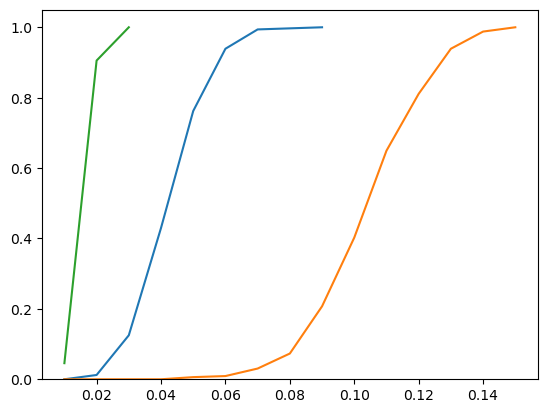

In [21]:
import matplotlib.pyplot as plt

values, bins = np.histogram(rnn_jsds, bins=np.arange(0, np.max(rnn_jsds) + 0.01, 0.01))
cdf = np.cumsum(values) / np.sum(values)
plt.plot(bins[1:], cdf)

values, bins = np.histogram(he_jsds, bins=np.arange(0, np.max(he_jsds) + 0.01, 0.01))
cdf = np.cumsum(values) / np.sum(values)
plt.plot(bins[1:], cdf)

values, bins = np.histogram(min_jsds, bins=np.arange(0, np.max(min_jsds) + 0.01, 0.01))
cdf = np.cumsum(values) / np.sum(values)
plt.plot(bins[1:], cdf)

plt.ylim(0, 1.05)

In [ ]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

In [ ]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

In [ ]:
# torch.save(gru, 'models/gru-0504.pth')
# torch.save(s2h, 'models/s2h-0504.pth')

In [ ]:
class SizeDecoder(torch.nn.Module):
    def __init__(self, output_dim, hidden_dims, latent_dim):
        super(SizeDecoder, self).__init__()
        self.decoder = torch.nn.ModuleList()
        in_dim = latent_dim
        for h_dim in hidden_dims:
            self.decoder.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim,),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x: Tensor) -> List[Tensor]:
        for module in self.decoder:
            x = module(x)
        result = self.output(x)
        result = F.softmax(result, dim=1)
        return result
    
decoder = torch.load('models/size-decoder-0425.pth')
gru = torch.load('models/gru-0504.pth')
s2h = torch.load('models/s2h-0504.pth')

In [ ]:
from scipy.stats import entropy
from tqdm import tqdm
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def sample_noisy_dataset(n, seed):
    torch.manual_seed(seed)
    dataset = []
    for i in tqdm(range(n)):
        latent_dim = 32
        z = torch.randn((1, latent_dim)).to(device)
        size = decoder(z)
        size = size.squeeze().detach().to('cpu').numpy()
        size[size < 1e-3] = 0
        size /= size.sum()

        dis = []
        for j in range(1000):
            loss = JSD(size, sizedata[j])
            dis.append(loss)

        pair = np.argmin(dis)
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size, target_set[pair][ran_index]])
        
    return dataset